# Linearizing Flow: Baseline Tests

The purpose of this notebook is to explore and visualize different ways of establishing a linearizing flow, based from the MCR^2 framework

In [2]:
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
# import geoopt
import torch
# import itertools
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import tqdm

import scipy.io as spio
# import open3d as o3d
import networkx
import imageio
import os
import re

import torchvision.datasets as datasets
import torchvision.transforms as transforms

# import open3d as o3d

In [3]:
# dimension of data
d = 3
# number of samples
n = 100

In [16]:
Z = np.random.randn(5,30)
C = np.linalg.inv(np.eye(5) + Z@Z.T)
z = Z[:,2]
print((z.T@C@z) / (z.T@z))
# print(z.T@z)

0.03341902135203737


In [4]:
# Set random seed
torch.manual_seed(42);

In [5]:
Z_0 = torch.randn(3,10)
Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0))
G = Z_0.t() @ Z_0
Z_1 = torch.randn(3,10)
Z_1 = Z_1 / np.sqrt(np.square(Z_1).sum(axis=0))
G_1 = Z_1.t() @ Z_1
# print(G)
# print(G_1 - G)
# print((G_1 - G)[G > 0])
print((G_1 - G)[G > 0].pow(2).sum())
# print(G > 0)

tensor(22.0121)


# Classes and Functions

In [6]:
# MAIN MODEL CODE
# Implemented as a PyTorch "NN" class, the "weights" here are
# the features Z, and the "forward pass" is the MCR^2 expansion term

# Built-in SGD component, tracks which part of the seed we are currently
# on

# One class, compression term only


class LinearizationFlow(nn.Module):

    def __init__(self, eps2, center, Z_0, K, delta, lambd):
        super(LinearizationFlow, self).__init__();
        # global vars init
        # dimension of data
        self.d = Z_0.shape[0];
        # number of data points
        self.n = Z_0.shape[1];
        # epsilon^2 parameter of MCR2 framework
        self.eps2 = eps2;
        # estimated max curvature of manifold underlying Z_0
        self.K = torch.tensor(K);
        # do we center data in loss computation?
        self.center = center;

        # Initialize features Z from given init Z_0
        self.Z = nn.Parameter(Z_0);
        # gram matrix of init
        self.gram_0 = Z_0.t() @ Z_0
        self.edm_0 = torch.diag(self.gram_0).reshape((n,1))@torch.ones((1,n)) \
            + torch.ones((n,1))@torch.diag(self.gram_0).reshape((1,n)) \
            - 2*self.gram_0
        # used for ReLU
        self.zeros = torch.zeros(self.edm_0.shape)

        # give an upper bound estimation on the initial RDM underlying Z_0
        edm_max = torch.max(self.edm_0)
        edm_min = torch.min(self.edm_0)
        # proper parameter for the exponential weighting
        alpha = torch.log(self.K) / (edm_max - edm_min)
        self.rdm_0 = self.edm_0*torch.exp(alpha*(self.edm_0 - edm_min))
        # observed indices for "close enough" points
        # self.Sigma = self.gram_0 > delta
        self.rdm_max = torch.max(self.rdm_0)
        self.delta = delta
        # amount regularization applies
        self.lambd = lambd

    def forward(self):

        if self.center:
            Zc = self.Z - torch.mean(self.Z, dim=1, keepdim=True);
        else:
            Zc = self.Z;
        # estimated covariance from samples
        C = (1/self.n)*Zc @ Zc.t();

        # mcr2 = torch.log(torch.det(torch.eye(self.d) + (self.d/self.eps2)*C)) + (self.d / (self.d+self.n))*torch.log(1 + torch.mean(self.Z, dim=1, keepdim=True).pow(2).sum()/self.eps2);
        mcr2 = torch.logdet(torch.eye(self.d) + (self.d/self.eps2)*C);
        # GRAM REGULARIZATIONS
        # metric_reg = 0.5*((self.Z.t()@self.Z - self.gram_0)*torch.exp(self.delta*(self.gram_0 - torch.ones(self.gram_0.shape)))).pow(2).sum()
        # metric_reg = torch.exp(self.delta*(self.gram_0 - torch.ones(self.gram_0.shape).pow(2))).sum()
        # metric_reg = 0.5*((self.Z.t()@self.Z - self.gram_0)).pow(2).sum()

        # EDM REGULARIZATIONS
        Z_gram = self.Z.t()@self.Z
        Z_EDM = torch.diag(Z_gram).reshape((n,1))@torch.ones((1,n)) \
            + torch.ones((n,1))@torch.diag(Z_gram).reshape((1,n)) \
            - 2*Z_gram

        # metric_reg = 0.5*((Z_EDM - self.edm_0)*torch.exp(-1*self.delta*(self.edm_0))).pow(2).sum()

        metric_reg = -1*(Z_EDM*(torch.exp(2*(self.rdm_0 - self.rdm_max)))).sum()
        # metric_reg = torch.log(torch.det(torch.eye(self.n) + self.delta*torch.max(self.rdm_0 - Z_EDM, self.zeros)))
        
        return mcr2 + self.lambd*metric_reg;
        # return self.lambd*metric_reg;

# # SGD component. NOTE: this does not update ALL data points at each GD update, just
# # the ones used for the stochastic gradient.
# class MCR2ExpansionSGD(nn.Module):

#     def __init__(self, batch_size, eps2, center, Z_0):
#         super(MCR2ExpansionSGD, self).__init__();
#         # global vars init
#         # dimension of data
#         self.d = Z_0.shape[0];
#         # number of data points
#         self.n = Z_0.shape[1];
#         self.batch_size = batch_size;
#         # epsilon^2 parameter of MCR2 framework
#         self.eps2 = eps2;
#         # do we center data in loss computation?
#         self.center = center;
#         # counter for sgd iterations
#         self.sgd_count = 0;
#         self.sgd_perm = torch.randperm(self.n);

#         # Initialize features Z from given init Z_0
#         self.Z = nn.Parameter(Z_0);

#     def forward(self):
#         # estimated second moments from samples
#         Z_sgd = self.Z[:,self.sgd_perm[self.sgd_count:self.sgd_count+self.batch_size]];
        
#         if self.center:
#             Zc = Z_sgd - torch.mean(Z_sgd, dim=1, keepdim=True);
#         else:
#             Zc = Z_sgd;

#         # refresh sgd count and perm if needed
#         self.sgd_count = (self.sgd_count + self.batch_size) % self.n;
#         # restart once end of data
#         if self.sgd_count == 0:
#             self.sgd_index = torch.randperm(self.n);

#         # estimated covariance from samples
#         C = (1/self.batch_size)*Zc @ Zc.t();
        
#         return -torch.log(torch.det(torch.eye(self.d) + (self.d/self.eps2)*C));

In [15]:
def experiment(LinFlow, lr, epochs, epoch_len, save=True, exp_name = ''):
    opt = optim.SGD(LinFlow.parameters(), lr=lr)

    # visualization stuff
    fig = plt.figure();
    ax = plt.axes(projection="3d")
    f.set_xlabel('X')
    f.set_ylabel('Y')
    f.set_zlabel('Z')
    Z_0 = LinFlow.Z.detach().clone().numpy()
    # to set the scale
    scatter = ax.scatter3D(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

    # Uncomment to set the scale
    ax.autoscale(False)
    images = []

    # create new directory for visualization

    #check if main directory has been made
    if not os.path.exists('./plots/'):
        os.mkdir('./plots/')
        os.mkdir('./plots/gifs/')
        os.mkdir('./plots/image_sequences/')

     # make plots directory if it doesnt exist
    file_num = -1
    for filename in os.listdir('./plots/image_sequences'):
        if '_' in filename:
            file_num_new = int(re.split('_|-', filename)[-2])
            if file_num_new > file_num:
                file_num = file_num_new
    os.mkdir(f'./plots/image_sequences/exp_{file_num+1}-{exp_name}')

    for i in range(epochs*epoch_len):
        LinFlow.zero_grad()
        # forward call of LinFlow
        loss = LinFlow()
            

        loss.backward()
        # GD step
        opt.step()
        # renormalization step
        # with torch.no_grad():
            # normalize all features
        	# LinFlow.Z.data = LinFlow.Z.data / torch.sqrt(torch.square(LinFlow.Z.data).sum(axis=0));
            # normalize full Z-matrix
            # first mean-center
            # LinFlow.Z.data = LinFlow.Z.data - torch.mean(LinFlow.Z.data, dim=1, keepdim=True);
            # then normalize, note doesnt destroy centering
            # LinFlow.Z.data = LinFlow.Z.data * np.sqrt(n) / torch.sqrt(torch.square(LinFlow.Z.data).sum());
        
        # take a snapshot of frame to collect into GIF
        # Graph for initial distribution
        Z_np = LinFlow.Z.detach().clone().numpy();

        if (i % epoch_len == 0):
            print(f'epoch {i // epoch_len}: CR {loss}')
            # figure = plt.figure();
            # f = figure.add_subplot(111, projection='3d');
            if save:
                scatter.remove()

                scatter = ax.scatter3D(Z_np[0,:], Z_np[1,:], Z_np[2,:], c='r', s = 6)
                img_path = f'./plots/image_sequences/exp_{file_num+1}-{exp_name}/lin_flow_step{i}.jpg'
                plt.savefig(img_path)
                images.append(imageio.imread(img_path))

    print(f'Done with optimization! Final loss: {loss}')
    print('Saving gif...')
    # set the name for the next saved gif
    file_num = -1
    for filename in os.listdir('./plots/gifs'):
        if '_' in filename:
            file_num_new = int(re.split('_|\.|-', filename)[-3])
            if file_num_new > file_num:
                file_num = file_num_new
    imageio.mimsave(f'plots/gifs/gif_{file_num + 1}-{exp_name}.gif', images)
    print('Done!')


In [39]:
hi = torch.randn(3,3)
print(hi)
zeros = torch.zeros(hi.shape)
print(torch.max(hi, zeros))

tensor([[ 0.3415, -0.0716, -0.0909],
        [-1.3297, -0.5426,  0.5471],
        [ 0.6431, -0.7905, -0.9058]])
tensor([[0.3415, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5471],
        [0.6431, 0.0000, 0.0000]])


# Run Test
Below code is where to specify what test to run

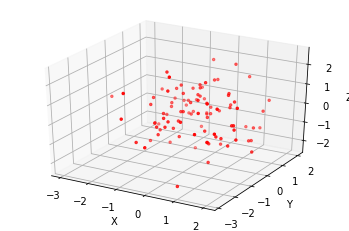

17.66290725748092


In [8]:
##################### VISUALIZE INIT DATA ##################

# projected sin wave
Z_0 = np.zeros((d,n))
for i in range(n):
	Z_0[0,i] = (i+1)/n;
	Z_0[1,i] = np.sin((i+1)/n*1.1*np.pi);
	Z_0[2,i] = 1;


# required normalization
Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0));



figure = plt.figure()
f = figure.add_subplot(111, projection='3d')

f.scatter(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

print( np.sqrt(np.square(Z_0).sum()))


epoch 0: CR 30.054895401000977
epoch 1: CR 30.03485870361328
epoch 2: CR 30.014684677124023
epoch 3: CR 29.994365692138672
epoch 4: CR 29.97390365600586
epoch 5: CR 29.953292846679688
epoch 6: CR 29.93253517150879
epoch 7: CR 29.91162872314453
epoch 8: CR 29.89056968688965
epoch 9: CR 29.86935806274414
epoch 10: CR 29.847991943359375
epoch 11: CR 29.826465606689453
epoch 12: CR 29.804780960083008
epoch 13: CR 29.782936096191406
epoch 14: CR 29.760927200317383
epoch 15: CR 29.738754272460938
epoch 16: CR 29.716411590576172
epoch 17: CR 29.693899154663086
epoch 18: CR 29.671218872070312
epoch 19: CR 29.648361206054688
epoch 20: CR 29.62532615661621
epoch 21: CR 29.60211944580078
epoch 22: CR 29.578725814819336
epoch 23: CR 29.555150985717773
epoch 24: CR 29.531389236450195
epoch 25: CR 29.5074405670166
epoch 26: CR 29.483301162719727
epoch 27: CR 29.458969116210938
epoch 28: CR 29.434438705444336
epoch 29: CR 29.409709930419922
epoch 30: CR 29.384782791137695
epoch 31: CR 29.359649658203

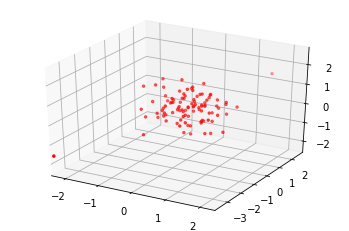

In [17]:
############################## RUN EXPERIMENT ##############w
# Z_0 = np.zeros((d,n))
# for i in range(n):
# 	Z_0[0,i] = (i+1)/n;
# 	Z_0[1,i] = np.sin((i+1)/n*1.3*np.pi);
# 	Z_0[2,i] = 1;


# # required normalization
# Z_0 = Z_0 / np.sqrt(np.square(Z_0).sum(axis=0));
# Z_0 = torch.from_numpy(Z_0).float();

# Gaussian data
Z_0_np = np.random.randn(d,n)
Z_0 = torch.from_numpy(Z_0_np).float();

LinFlow = LinearizationFlow(eps2=0.0001, center=True, Z_0=Z_0, K=1, delta=1, lambd=0.01)

experiment(LinFlow, lr=0.005, epochs = 150, epoch_len = 20, exp_name='together')
# make gif and organize generated images
# !python3 stitch_jpgs.py


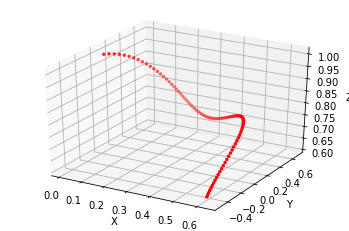

In [62]:
# Graph for initial distribution
figure = plt.figure()
f = figure.add_subplot(111, projection='3d')

f.scatter(Z_0[0,:], Z_0[1,:], Z_0[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

In [65]:
print(Z_0.shape)

torch.Size([3, 100])


In [67]:
print(torch.sum(torch.pow(Z_0 - Z_0[:,0].reshape((3,1)), 2), axis=0))

tensor([0.0000, 0.0017, 0.0069, 0.0153, 0.0267, 0.0409, 0.0575, 0.0763, 0.0968,
        0.1187, 0.1417, 0.1655, 0.1897, 0.2142, 0.2387, 0.2629, 0.2867, 0.3100,
        0.3325, 0.3543, 0.3752, 0.3952, 0.4142, 0.4322, 0.4491, 0.4650, 0.4798,
        0.4935, 0.5061, 0.5176, 0.5281, 0.5375, 0.5459, 0.5532, 0.5595, 0.5648,
        0.5691, 0.5724, 0.5748, 0.5762, 0.5767, 0.5762, 0.5749, 0.5727, 0.5696,
        0.5658, 0.5610, 0.5556, 0.5493, 0.5424, 0.5348, 0.5266, 0.5178, 0.5085,
        0.4987, 0.4886, 0.4782, 0.4676, 0.4569, 0.4463, 0.4358, 0.4256, 0.4159,
        0.4068, 0.3984, 0.3908, 0.3844, 0.3791, 0.3752, 0.3728, 0.3719, 0.3727,
        0.3752, 0.3795, 0.3856, 0.3934, 0.4030, 0.4141, 0.4268, 0.4409, 0.4563,
        0.4728, 0.4902, 0.5084, 0.5273, 0.5466, 0.5662, 0.5860, 0.6059, 0.6256,
        0.6451, 0.6644, 0.6832, 0.7016, 0.7195, 0.7368, 0.7535, 0.7695, 0.7849,
        0.7995])


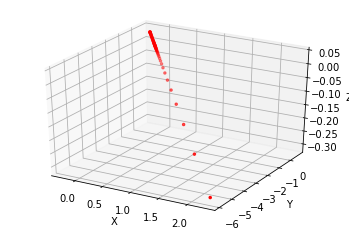

[1.0000000e+01 2.2573248e-07 2.1196495e-08]


In [105]:
# Graph for final distribution
figure = plt.figure()
f = figure.add_subplot(111, projection='3d')
Z_np = LinFlow.Z.detach().clone().numpy();

f.scatter(Z_np[0,:], Z_np[1,:], Z_np[2,:], c='r', s = 6)

f.set_xlabel('X')
f.set_ylabel('Y')
f.set_zlabel('Z')

plt.show()

u, s, v = np.linalg.svd(Z_np)
print(s)

In [79]:
pointclud = Z_np.T
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pointclud)
o3d.visualization.draw_geometries([pcd])

In [49]:
u, s, v = np.linalg.svd(Z_np)
print(s)

[1.0000000e+01 3.9621219e-07 4.9564083e-08]


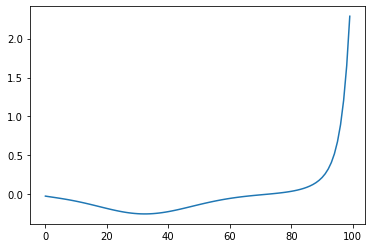

In [109]:
plt.plot(np.arange(100),Z_np[0,:])

# EDM tests

testing some properties of the EDM for benign sets

(array([1., 1., 0., 0., 1., 0., 2., 0., 1., 1.]),
 array([0.        , 0.00089555, 0.00179109, 0.00268664, 0.00358218,
        0.00447773, 0.00537327, 0.00626882, 0.00716436, 0.00805991,
        0.00895545]),
 <a list of 10 Patch objects>)

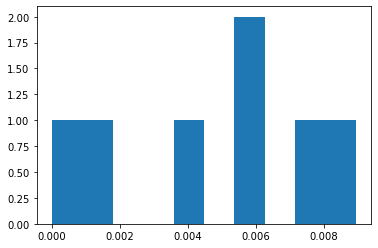

In [34]:
d = 1
n = 100

Z = np.random.randn(d, n)

G = Z.T@Z
EDM = np.diag(G).reshape((n,1))@np.ones((1,n)) \
            + np.ones((n,1))@ np.diag(G).reshape((1,n)) \
            - 2*G

EDM_col = EDM[0,:]
plt.hist(EDM_col[EDM_col < 0.01])


# LinFlow v2

new and improved!

In [23]:
print(np.diag(np.eye(4)))

[1. 1. 1. 1.]


In [22]:
Z = np.random.randn(3,5)
print(Z.mean(axis=0))

Z = Z / np.sqrt(np.sum(np.power(Z,2), axis=0, keepdims=True))
print(np.linalg.norm(Z[:,0]))

[ 0.63132261  1.03223307 -0.12289338  0.05622427 -0.1192407 ]
0.9999999999999999


In [307]:
# given observations of manifold Z in R^(d\times n), compute the next step
# of linearization flow
def linflow_step(Z,eps2,gamma):
	d = Z.shape[0]
	n = Z.shape[1]

	# STEP 1: compute gradient
	alpha = d/(n*eps2)
	g = np.linalg.inv(np.eye(d) + alpha*Z@Z.T)@Z

	# STEP 2: project gradient to normal directions
	# this step currently makes HUGE assumptions

	# approximated tangent space. Here, we assume that
	# Z is ordered along a 1D curve
	V = Z - np.roll(Z, 1, axis=1)
	# correct at endpoints
	V[0,:] = Z[1,:] - Z[0,:]

	# normalize tangent vectors
	V = V / np.sqrt(np.sum(np.power(V,2), axis=0, keepdims=True))

	# inner products between data points and tangent vectors
	innerGV = np.diag(g.T@V).reshape((1,n))

	# project gradient directions to normal bundle (normal spaces)
	g = g - innerGV * V

	# STEP 3: projected gradient descent

	Znew = Z - gamma*g
	# mean center
	Znew = Znew - np.mean(Znew,axis=1,keepdims=True)
	# global normalization
	Znew = Znew * n / np.sqrt(np.sum(np.power(Znew, 2)))
	return Znew

In [53]:
hi = np.random.randn(3,5)
print()

[[ 0.44331226]
 [-0.5340037 ]
 [ 0.29770836]]


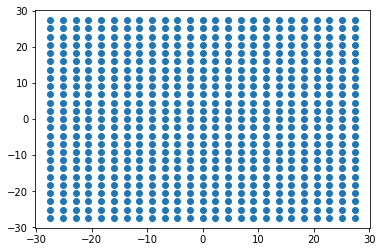

In [151]:
d = 4
sqrt_n = 25
n = sqrt_n**2

Z = np.zeros((d,n))
for i in range(sqrt_n):
	for j in range(sqrt_n):
		x = (-0.5 + (i+1)/sqrt_n)*2*np.pi
		y = (-0.5 + (j+1)/sqrt_n)*2*np.pi
		Z[0,j + sqrt_n*i] = x
		Z[1,j + sqrt_n*i] = y
		Z[2,j + sqrt_n*i] = np.sin(4*x)
		Z[3,j + sqrt_n*i] = np.sin(7*y)


# mean center
Z = Z - np.mean(Z,axis=1,keepdims=True)
# global normalization
Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

plt.scatter(Z[0,:], Z[1,:])

5.853156198498217e-13


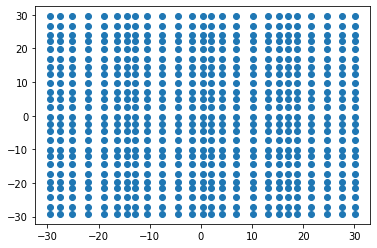

In [170]:

u, s, vt = np.linalg.svd(Z)
S = np.zeros(Z.shape)
S[:,:len(s)] = np.diag(s)
print(np.linalg.norm(u@S@vt - Z))
Y =  u[:,:2].T@Z

plt.scatter(Y[0,:], Y[1,:])

In [149]:
u,s,vt = np.linalg.svd(Z)
print(s)

[412.88115201 411.95747    160.01107121 157.61235458]


In [295]:
print(np.sqrt(np.sum(np.power(Z, 2))))

nan


step 0
step 1000
step 2000
step 3000
step 4000
step 5000
step 6000
step 7000
step 8000
step 9000
step 10000
step 11000


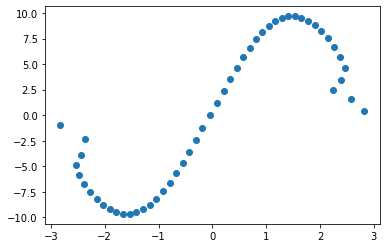

In [312]:
eps2 = 0.05
gamma = 0.001
Z = np.zeros((2,50))
for i in range(50):
	x = (-0.5 + (i+1)/50)*2*np.pi
	Z[0,i] = x
	Z[1,i] = 10*np.sin(x)



for i in range(12000):
	Z = linflow_step(Z, eps2, gamma)
	if i%1000 == 0:
		print(f'step {i}')

# u,s,vt = np.linalg.svd(Z)
# print(s)
plt.scatter(Z[0,:], Z[1,:])

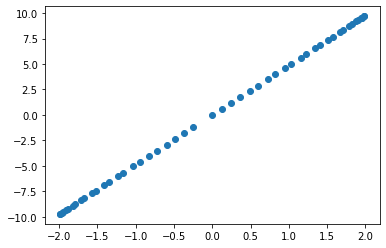

In [284]:
plt.scatter(Z[0,:], Z[1,:])

step 0
step 50
step 100
step 150
step 200
step 250
step 300
step 350
step 400
step 450
step 500
step 550
step 600
step 650
step 700
step 750
step 800
step 850
step 900
step 950
step 1000
step 1050
step 1100
step 1150
step 1200
step 1250
step 1300
step 1350
step 1400
step 1450
step 1500
step 1550
step 1600
step 1650
step 1700
step 1750
step 1800
step 1850
step 1900
step 1950
step 2000
step 2050
step 2100
step 2150
step 2200
step 2250
step 2300
step 2350
step 2400
step 2450
step 2500
step 2550
step 2600
step 2650
step 2700
step 2750
step 2800
step 2850
step 2900
step 2950
step 3000
step 3050
step 3100
step 3150
step 3200
step 3250
step 3300
step 3350
step 3400
step 3450
step 3500
step 3550
step 3600
step 3650
step 3700
step 3750
step 3800
step 3850
step 3900
step 3950
step 4000
step 4050
step 4100
step 4150
step 4200
step 4250
step 4300
step 4350
step 4400
step 4450
step 4500
step 4550
step 4600
step 4650
step 4700
step 4750
step 4800
step 4850
step 4900
step 4950
step 5000
step 5050
ste

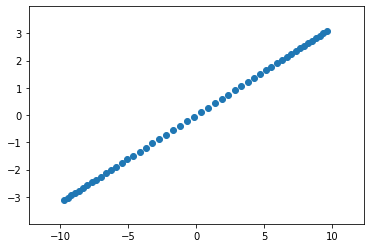

In [117]:

Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	Z[1,i] = np.sin(x)


# mean center
Z = Z - np.mean(Z,axis=1,keepdims=True)
# global normalization
Z = Z * n / np.sqrt(np.sum(np.power(Z, 2)))

fig = plt.figure()
ax = plt.axes()


images = []
scatter = ax.scatter(Z[0, :], Z[1, :])
# Uncomment to set the scale
# ax.autoscale(False)

# create new directory for visualization

# check if main directory has been made
if not os.path.exists('./plots/'):
    os.mkdir('./plots/')
    os.mkdir('./plots/gifs/')
    os.mkdir('./plots/image_sequences/')

# # make plots directory if it doesnt exist
# file_num = -1
# for filename in os.listdir('./plots/image_sequences'):
#     if '_' in filename:
#         file_num_new = int(re.split('_|-', filename)[-2])
#         if file_num_new > file_num:
#             file_num = file_num_new
os.mkdir(f'./plots/image_sequences/exp_newlinflownoadjust')

eps2 = 0.05
gamma = 0.01
for i in range(10000):
    Z = linflow_step(Z, eps2, gamma)
    scatter.remove()

    scatter = ax.scatter(Z[0, :], Z[1, :])
    if i % 50 == 0:
        img_path = f'./plots/image_sequences/exp_newlinflownoadjust/lin_flow_step{i}.jpg'
        plt.savefig(img_path)
        images.append(imageio.imread(img_path))
        print(f'step {i}')

print('Saving gif...')
# set the name for the next saved gif
imageio.mimsave(f'plots/gifs/gif_newlinflownoadjust.gif', images)
print('Done!')


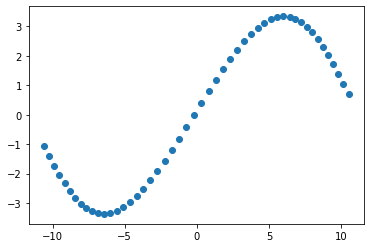

In [106]:

fig = plt.figure()
ax = plt.axes()
ax.scatter(Z[0,:],Z[1,:])
plt.show()

In [114]:
imageio.mimsave(f'plots/gifs/gif_newlinflow.gif', images)
print('Done!')

Done!


In [172]:
# load MNIST
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])
dataset = datasets.MNIST(root='.\michael-tests-data', train=True,
                         download=True, transform=transform)


9913344it [00:00, 25835164.26it/s]                             


Extracting .\michael-tests-data\MNIST\raw\train-images-idx3-ubyte.gz to .\michael-tests-data\MNIST\raw



29696it [00:00, 29487228.12it/s]         

Extracting .\michael-tests-data\MNIST\raw\train-labels-idx1-ubyte.gz to .\michael-tests-data\MNIST\raw



1649664it [00:00, 14096548.82it/s]                             


Extracting .\michael-tests-data\MNIST\raw\t10k-images-idx3-ubyte.gz to .\michael-tests-data\MNIST\raw



5120it [00:00, 5125259.30it/s]          


Extracting .\michael-tests-data\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\michael-tests-data\MNIST\raw



In [188]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=60000)
data,labels = next(iter(data_loader))
data = data.cuda()

In [189]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [260]:
Z = data[labels==2]
Z = Z.reshape((32,32,5958))
Z = Z.reshape((32**2,5958))

d = Z.shape[0]
n = Z.shape[1]

u, s, vt = torch.svd(Z)
# mean-center
Z = Z - Z.mean(axis=1,keepdims=True)
# global normalization
Z = Z * n / torch.sqrt(Z.pow(2).sum())

A = torch.eye(32**2)



In [259]:
# given observations of manifold Z in R^(d\times n), compute the next step
# of linearization flow
def linflow_step_torch(Z,A,eps2,gamma):
	d = Z.shape[0]
	n = Z.shape[1]

	# STEP 1: compute gradient
	alpha = d/(n*eps2)
	g = torch.linalg.inv(torch.eye(d) + alpha*Z@Z.t())@Z
	g_A = torch.linalg.inv(torch.eye(d) + alpha*Z@Z.t())

	# STEP 2: project gradient to normal directions
	# this step currently makes HUGE assumptions

	# approximated tangent space. Here, we assume that
	# Z is ordered along a 1D curve
	# V = np.roll(Z, 1, axis=1) - np.roll(Z, -1, axis=1)
	# # correct at endpoints
	# V[0,:] = Z[1,:] - Z[0,:]
	# V[-1,:] = Z[-1,:] - Z[-2,:]

	# # normalize tangent vectors
	# V = V / np.sqrt(np.sum(np.power(V,2), axis=0, keepdims=True))

	# # inner products between data points and tangent vectors
	# innerGV = np.diag(g.T@V).reshape((1,n))

	# # project gradient directions to normal bundle (normal spaces)
	# g = g - innerGV * V

	# STEP 3: projected gradient descent


	Znew = Z - gamma*g
	# mean center not needed, since linear operations
	# preserve mean-center
	# Znew = Znew - Znew.mean(axis=1,keepdims=True)
	# global normalization
	normalize = n / torch.sqrt(Znew.pow(2).sum())
	Znew = Znew * normalize

	Anew = normalize*(torch.eye(d) - gamma*g_A)@A

	return Znew, Anew

In [261]:
# calculate minimum distance squared
# gram = Z.t()@Z
# gram_diag = torch.diag(torch.diag(gram))
# EDM = torch.ones(gram.shape)@gram_diag + gram_diag@torch.ones(gram.shape) - 2*gram
# min_dist_2 = (EDM[EDM > 0]).min()

eps2 = min_dist_2*2
gamma = 0.1

for i in range(4000):
	Z, A = linflow_step_torch(Z, A, eps2, gamma)
	Z = Z.detach()
	if i%100 == 0:
		print(f'step {i}')

u,s,vt = torch.linalg.svd(Z)
print(len(s[s>1e-6]))

step 0
step 100
step 200
step 300
step 400
step 500
step 600
step 700
step 800
step 900
step 1000
step 1100
step 1200
step 1300
step 1400
step 1500
step 1600
step 1700
step 1800
step 1900
step 2000
step 2100
step 2200
step 2300
step 2400
step 2500
step 2600
step 2700
step 2800
step 2900
step 3000
step 3100
step 3200
step 3300
step 3400
step 3500
step 3600
step 3700
step 3800
step 3900
step 4000
step 4100
step 4200
step 4300
step 4400
step 4500
step 4600
step 4700
step 4800
step 4900
step 5000
step 5100
step 5200
step 5300
step 5400
step 5500
step 5600
step 5700
step 5800
step 5900


KeyboardInterrupt: 

In [262]:
print(s)

tensor([1735.3969,  443.0468,  441.0703,  ...,    6.5820,    6.5253,
           6.4038])


In [265]:
gram = Z.t()@Z
gram_diag = torch.diag(torch.diag(gram))
EDM = torch.ones(gram.shape)@gram_diag + gram_diag@torch.ones(gram.shape) - 2*gram
print((EDM[EDM > 0]).max())

tensor(33923.2891)


In [268]:
Z_0 = data[labels==2]
Z_0 = Z_0.reshape((32,32,5958))
Z_0 = Z_0.reshape((32**2,5958))

d = Z_0.shape[0]
n = Z_0.shape[1]

# mean-center
Z_0 = Z_0 - Z_0.mean(axis=1,keepdims=True)
# global normalization
Z_0 = Z_0 * n / torch.sqrt(Z_0.pow(2).sum())

print(A@Z_0 - Z)

tensor([[-1.3185e-04, -1.3566e-04, -1.1778e-04,  ..., -1.0133e-04,
         -8.6784e-05, -6.9380e-05],
        [-2.2531e-05, -2.7120e-06,  1.7643e-05,  ...,  3.0279e-05,
          4.9949e-05,  7.0810e-05],
        [ 8.5115e-05,  1.0395e-04,  1.0514e-04,  ...,  1.0014e-04,
          1.0300e-04,  1.0371e-04],
        ...,
        [ 1.2946e-04,  1.4210e-04,  1.3041e-04,  ...,  1.1516e-04,
          1.0681e-04,  1.0133e-04],
        [ 6.1750e-05,  4.9114e-05,  2.9445e-05,  ...,  1.2875e-05,
         -8.2180e-06, -2.7597e-05],
        [-2.8968e-05, -4.4465e-05, -5.1141e-05,  ..., -5.5909e-05,
         -6.4015e-05, -7.0572e-05]])


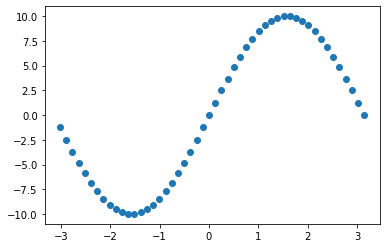

In [281]:
Z = np.zeros((2,50))
for i in range(50):
	x = (-0.5 + (i+1)/50)*2*np.pi
	Z[0,i] = x
	Z[1,i] = 10*np.sin(x)

plt.scatter(Z[0,:], Z[1,:])

In [282]:
u, s, vt = np.linalg.svd(Z)
print(u)
print(s)

[[-0.20067747 -0.97965737]
 [-0.97965737  0.20067747]]
[51.01262054  7.89541305]


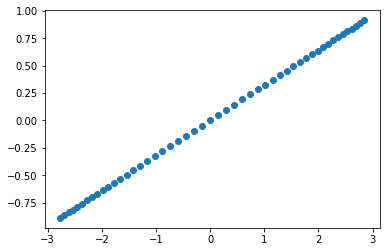

In [278]:
u_col = u[:,0].reshape((2,1))
W = u_col@u_col.T@Z
plt.scatter(W[0,:], W[1,:])

# Testing EDM-based PCA

In [124]:
class EDM_PCA(nn.Module):

    def __init__(self, X, u_0):
        super(EDM_PCA, self).__init__();
        # data
        self.X = X
        # projection vec
        self.u = nn.Parameter(u_0)

    def forward(self):

        d = X.shape[0]
        n = X.shape[1]

        U = self.u@self.u.t()
        # want to maximize the negative of this func
        return -((torch.eye(d) - U)@self.X).pow(2).sum() - (1/n)*torch.ones((1,n))@self.X.t()@U@self.X@torch.ones((n,1))

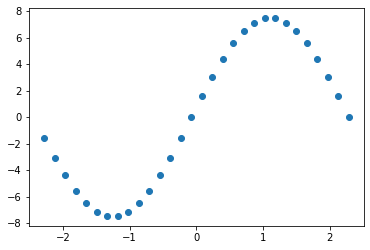

In [252]:
d = 2
n = 30
scale = 10

Z = np.zeros((d,n))
for i in range(n):
	x = (-0.5 + (i+1)/n)*2*np.pi
	Z[0,i] = x
	Z[1,i] = scale*np.sin(x)

Z = Z - Z.mean(axis=1,keepdims=True)
Z = n/np.linalg.norm(Z,'fro')*Z

plt.scatter(Z[0,:], Z[1,:])
plt.scatter(Z[0,8], Z[1,8],col)
plt.scatter(Z[0,21], Z[1,21])


# A = np.eye(d)
# A[0,0] = 2
# Z = np.random.randn(d,n)
# Z = A@Z


In [135]:
u_0 = torch.randn((d,1))
u_0 = u_0 / torch.sqrt(u_0.pow(2).sum())
X = torch.Tensor(Z)

edm_pca = EDM_PCA(X, u_0)
opt = optim.SGD(edm_pca.parameters(), lr=0.00001)

for i in range(10000):
	edm_pca.zero_grad()
	# forward call of LinFlow
	loss = edm_pca()

	loss.backward()
	# GD step
	opt.step()
	# renormalization step
	with torch.no_grad():
		edm_pca.u.data = edm_pca.u.data / torch.sqrt((edm_pca.u.data).pow(2).sum());

	if i%100 == 0:
		print(f'g step {i}: {torch.linalg.norm(edm_pca.u.grad)}')

print('done!')

g step 0: 1441.732421875
g step 100: 195.523681640625
g step 200: 8.893322944641113
g step 300: 0.4031272828578949
g step 400: 0.018336255103349686
g step 500: 0.0009728703880682588
g step 600: 0.0007176921353675425
g step 700: 0.0007176921353675425
g step 800: 0.0007176921353675425
g step 900: 0.0007176921353675425
g step 1000: 0.0007176921353675425
g step 1100: 0.0007176921353675425
g step 1200: 0.0007176921353675425
g step 1300: 0.0007176921353675425
g step 1400: 0.0007176921353675425
g step 1500: 0.0007176921353675425
g step 1600: 0.0007176921353675425
g step 1700: 0.0007176921353675425
g step 1800: 0.0007176921353675425
g step 1900: 0.0007176921353675425
g step 2000: 0.0007176921353675425
g step 2100: 0.0007176921353675425
g step 2200: 0.0007176921353675425
g step 2300: 0.0007176921353675425
g step 2400: 0.0007176921353675425
g step 2500: 0.0007176921353675425
g step 2600: 0.0007176921353675425
g step 2700: 0.0007176921353675425
g step 2800: 0.0007176921353675425
g step 2900: 0.00

In [136]:
print(edm_pca.u.data)

tensor([[ 0.9797],
        [-0.2002]])


In [329]:
edm0 = np.zeros((n,n))
for i in range(n):
	for j in range(n):
		edm0[i,j] = np.power(np.linalg.norm(Z[:,i] - Z[:,j]),2)


u, s, vt = np.linalg.svd(Z)
# print(u)
# print(s)

u_1 = u[:,1].reshape((2,1))

Z_proj = Z - u_1@u_1.T@Z
Z_proj = n/np.linalg.norm(Z_proj,'fro')*Z_proj

edm = np.zeros((n,n))
edm_sum = 0
for i in range(n):
	for j in range(n):
		if i != j:
			edm[i,j] = np.power(np.linalg.norm(Z_proj[:,i] - Z_proj[:,j]),2) / edm0[i,j]

# u_2 = np.random.randn(2,1)
# u_2 = u_2 / np.sqrt(np.sum(np.power(u_2,2)))
u_2 = np.zeros((2,1))
u_2[1] = 1

Z_proj = Z - u_2@u_2.T@Z
Z_proj = n/np.linalg.norm(Z_proj,'fro')*Z_proj
edm2 = np.zeros((n,n))
edm_sum2 = 0
for i in range(n):
	for j in range(n):
		if i != j:
			edm2[i,j] = np.power(np.linalg.norm(Z_proj[:,i] - Z_proj[:,j]),2)/ edm0[i,j]


In [278]:

print(np.sum(np.power(edm,2)))
print(np.sum(np.power(edm2,2)))

710.6449321233534
16061.723613590344


In [257]:
np.unravel_index(261,(n,n))

(8, 21)

In [256]:
print(np.argmax(edm0 - edm))
print(np.argmax(edm0 - edm2))

29
261


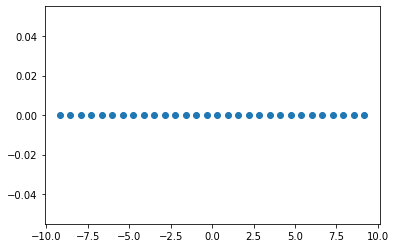

In [251]:

plt.scatter(Z_proj[0,:], Z_proj[1,:])

In [112]:
X = torch.randn(10,100)

In [117]:
u = torch.randn(10,1)
u = u / torch.sqrt(u.pow(2).sum())
print(torch.ones((1,100))@X.t()@u@u.t()@X@torch.ones((100,1)))

tensor([[86.1021]])


In [372]:
def energy_func(Z, u):
    # Z_proj = Z - u@u.T@Z
    # Z_proj = n/np.linalg.norm(Z_proj,'fro')*Z_proj
    # return np.inner((Z_proj.T@Z_proj).flatten(), (gamma_s - gamma).flatten())

    U_stacked = np.ones(Z.shape)*u
    A = (Z.T @ U_stacked - U_stacked.T @ Z)*gamma
    # return np.sum(np.power(np.abs(A),2))
    return np.max(np.abs(A))

for i in range(100000):

    gram = Z.T@Z
    edm = np.diag(gram).reshape((n,1))@np.ones((1,n)) \
                + np.ones((n,1))@np.diag(gram).reshape((1,n)) \
                - 2*gram

    gamma = np.divide(1,np.eye(n) + edm)

    # u, s, vt = np.linalg.svd(Z)
    # u_1 = u[:,1].reshape((2,1))
    u_1 = np.random.randn(2,1)
    u_1 = u_1 / np.linalg.norm(u_1)

    edm_sum = energy_func(Z, u_1)
    u_2 = np.zeros((2,1))
    u_2[1] = 1

    edm_sum2 = energy_func(Z, u_2)
    if edm_sum2 > edm_sum:
        print(f'not min! iter {i}, proposed min value: {edm_sum2}')
        print(f'discovered max: {edm_sum}')
        print(f'vec: {u_1}')

In [351]:
a = np.ones((2,2))
b = np.random.randn(2,1)
print(a)
print(b)
print(a*b)

[[1. 1.]
 [1. 1.]]
[[0.88850222]
 [0.16673973]]
[[0.88850222 0.88850222]
 [0.16673973 0.16673973]]


In [356]:
U_stacked = np.ones(Z.shape)*u_1
A = Z.T @ U_stacked - U_stacked.T @ Z
print(A)
# A2 = np.zeros((n,n))
# for i in range(n):
# 	A2[i,j]

[[ 0.00000000e+00  1.02412859e+00  1.96790769e+00  2.79557174e+00
   3.47642996e+00  3.98620769e+00  4.30810732e+00  4.43354240e+00
   4.36251293e+00  4.10360536e+00  3.67361731e+00  3.09682342e+00
   2.40391448e+00  1.63065605e+00  8.16325342e-01  1.99463535e-03
  -7.71263797e-01 -1.46417274e+00 -2.04096662e+00 -2.47095468e+00
  -2.72986225e+00 -2.80089171e+00 -2.67545663e+00 -2.35355701e+00
  -1.84377927e+00 -1.16292106e+00 -3.35257010e-01  6.08522091e-01
   1.63265068e+00  2.69785155e+00]
 [-1.02412859e+00  0.00000000e+00  9.43779101e-01  1.77144315e+00
   2.45230136e+00  2.96207910e+00  3.28397872e+00  3.40941381e+00
   3.33838434e+00  3.07947677e+00  2.64948871e+00  2.07269483e+00
   1.37978589e+00  6.06527455e-01 -2.07803252e-01 -1.02213396e+00
  -1.79539239e+00 -2.48830133e+00 -3.06509522e+00 -3.49508327e+00
  -3.75399084e+00 -3.82502031e+00 -3.69958523e+00 -3.37768560e+00
  -2.86790787e+00 -2.18704965e+00 -1.35938560e+00 -4.15606503e-01
   6.08522091e-01  1.67372296e+00]
 [-1.9